In [ ]:
# Load Libraries
import pandas as pd
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5270')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5270


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5270')
data1 = loadmat('Data.mat')
data2 = loadmat('Data.mat')
a_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2),'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel(),'physics_out':data1['physics_out'].ravel(),'ln_freqQAmpI_filt':data1['ln_freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['ShearStress'].ravel(), 'TTF':data1['TTF'].ravel()})
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2),'ln_V_V0':data2['ln_V_V0'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt','ln_freqQAmpI_filt', 'C_filt','ln_V_V0','Time','SS','TTF','physics_out']]
df_SS = df[['freqQAmpI_filt', 'C_filt', 'SS']]
df_TTF = df[['freqQAmpI_filt', 'C_filt', 'TTF']]
df_V = df[['freqQAmpI_filt', 'C_filt', 'ln_V_V0']]
df_PhyOut = df[['freqQAmpI_filt', 'C_filt', 'physics_out']]
df_A = df_A = df[['freqQAmpI_filt','C_filt','ln_freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','ln_V_V0']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS   ln_V_V0
0       5.651236 -2.068134
1       5.652434 -2.211235
2       5.653611 -2.173495
3       5.656168 -2.155145
4       5.656270 -2.119427
...          ...       ...
132394  5.465790 -2.378289
132395  5.463760 -2.211235
132396  5.465891 -2.312331
132397  5.464572 -2.401279
132398  5.463273 -2.035344

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (TTF)
arr = df_TTF.to_numpy()
n_steps = 300
xdf, ydf_TTF = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_SR = create_timesteps(arr, n_steps)
ydf_SR[ydf_SR < -2] = -2

# Preprocessing (Physics_Out)
arr = df_PhyOut.to_numpy()
n_steps = 300
xdf, phy_outdf = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, Adf = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, WVdf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (TTF), Y = ', np.shape(ydf_TTF))
print('Target shape (V), Y = ', np.shape(ydf_SR))
print('Target shape (A), Y = ', np.shape(Adf))
print('Target shape (WV), Y = ', np.shape(WVdf))
print('Target shape (Physics_Out), Y = ', np.shape(phy_outdf))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (TTF), Y =  (132099,)
Target shape (V), Y =  (132099,)
Target shape (A), Y =  (132099,)
Target shape (WV), Y =  (132099,)
Target shape (Physics_Out), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (TTF)
x_train, x_test, y_train_TTF, y_test_TTF = train_test_split(xdf, ydf_TTF, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_TTF, Y_val_TTF = train_test_split(x_train, y_train_TTF, test_size=0.125, shuffle=False)

# Split into train-val-test (SR)
x_train, x_test, y_train_SR, y_test_SR = train_test_split(xdf, ydf_SR, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SR, Y_val_SR = train_test_split(x_train, y_train_SR, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[85864:92469]
Y_train_SS = Y_train_SS[85864:92469]
Y_train_TTF = Y_train_TTF[85864:92469]
Y_train_SR = Y_train_SR[85864:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 6605
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler(feature_range=(0, 1))
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: TTF
scaler_ttf = MinMaxScaler(feature_range=(0, 1))
Y_train_TTF = pd.DataFrame(scaler_ttf.fit_transform(Y_train_TTF.reshape(-1, 1)))
Y_val_TTF = pd.DataFrame(scaler_ttf.transform(Y_val_TTF.reshape(-1, 1)))
y_test_TTF = pd.DataFrame(scaler_ttf.transform(y_test_TTF.reshape(-1, 1)))

In [ ]:
# # Normalize the output: SR
scaler_sr = MinMaxScaler(feature_range=(-1, 1))
Y_train_SR = pd.DataFrame(scaler_sr.fit_transform(Y_train_SR.reshape(-1, 1)))
Y_val_SR = pd.DataFrame(scaler_sr.transform(Y_val_SR.reshape(-1, 1)))
y_test_SR = pd.DataFrame(scaler_sr.transform(y_test_SR.reshape(-1, 1)))

In [ ]:
# Define PINN
def MLP_Physics():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')

  # Prediction: Shear Stress + TTF
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)

  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  ttf_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  sr_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,ttf_pred,sr_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Physics()
model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 X_train (InputLayer)        [(None, 600)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  76928     ['X_train[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   8256      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 32)                   2080      ['dense_1[0][0]']             
                                                                                              

Train on 6605 samples, validate on 13210 samples
Epoch 1/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.4298 - dense_5_loss: 0.1042 - dense_6_loss: 0.1035 - dense_7_loss: 0.2222 - dense_5_mse: 0.1042 - dense_6_mse: 0.1035 - dense_7_mse: 0.2222

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6605/6605 [==============================] - 3s 522us/sample - loss: 0.4230 - dense_5_loss: 0.1014 - dense_6_loss: 0.1025 - dense_7_loss: 0.2188 - dense_5_mse: 0.1016 - dense_6_mse: 0.1026 - dense_7_mse: 0.2188 - val_loss: 0.3086 - val_dense_5_loss: 0.0768 - val_dense_6_loss: 0.0902 - val_dense_7_loss: 0.1416 - val_dense_5_mse: 0.0768 - val_dense_6_mse: 0.0902 - val_dense_7_mse: 0.1416
Epoch 2/100
6605/6605 [==============================] - 2s 310us/sample - loss: 0.2292 - dense_5_loss: 0.0559 - dense_6_loss: 0.0750 - dense_7_loss: 0.0985 - dense_5_mse: 0.0559 - dense_6_mse: 0.0749 - dense_7_mse: 0.0983 - val_loss: 0.2457 - val_dense_5_loss: 0.0766 - val_dense_6_loss: 0.0792 - val_dense_7_loss: 0.0898 - val_dense_5_mse: 0.0766 - val_dense_6_mse: 0.0792 - val_dense_7_mse: 0.0898
Epoch 3/100
6605/6605 [==============================] - 2s 359us/sample - loss: 0.1961 - dense_5_loss: 0.0640 - dense_6_loss: 0.0687 - dense_7_loss: 0.0634 - dense_5_mse: 0.0640 - dense_6_mse: 0.0686 - dense_7

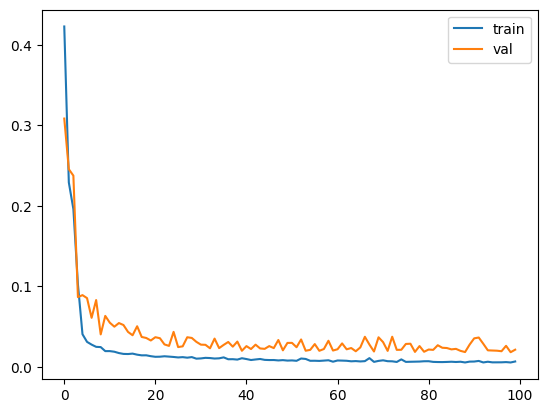

---Training time: 171.09764957 seconds ---


In [ ]:
# Train The Model
start_time = time.time()
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
callbacks_list = [earlystop]
history = model.fit([X_train],[Y_train_SS,Y_train_TTF,Y_train_SR], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_TTF,Y_val_SR]), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,]
y_predtrain_TTF =np.array(y_predtrain)[1,]
y_predtrain_SR =np.array(y_predtrain)[2,]

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

train_r2_TTF = r2_score(Y_train_TTF, y_predtrain_TTF)
train_rmse_TTF = np.sqrt(mean_squared_error(Y_train_TTF, y_predtrain_TTF))

train_r2_SR = r2_score(Y_train_SR, y_predtrain_SR)
train_rmse_SR = np.sqrt(mean_squared_error(Y_train_SR, y_predtrain_SR))

# Model Performance: Validation
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,]
y_predval_TTF =np.array(y_predval)[1,]
y_predval_SR =np.array(y_predval)[2,]

val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

val_r2_TTF = r2_score(Y_val_TTF, y_predval_TTF)
val_rmse_TTF = np.sqrt(mean_squared_error(Y_val_TTF, y_predval_TTF))

val_r2_SR = r2_score(Y_val_SR, y_predval_SR)
val_rmse_SR = np.sqrt(mean_squared_error(Y_val_SR, y_predval_SR))

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS = np.array(y_predtest)[0,]
y_predtest_TTF =np.array(y_predtest)[1,]
y_predtest_SR =np.array(y_predtest)[2,]

test_r2_SS = r2_score(y_test_SS, y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

test_r2_TTF = r2_score(y_test_TTF, y_predtest_TTF)
test_rmse_TTF = np.sqrt(mean_squared_error(y_test_TTF, y_predtest_TTF))

test_r2_SR = r2_score(y_test_SR, y_predtest_SR)
test_rmse_SR = np.sqrt(mean_squared_error(y_test_SR, y_predtest_SR))

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (TTF) - %0.5f, Train (SR) - %0.5f" %(train_r2_SS, train_r2_TTF, train_r2_SR))
print("R2 scores: Val (SS) - %0.5f, Val (TTF) - %0.5f, Val (SR) - %0.5f" %(val_r2_SS, val_r2_TTF, val_r2_SR))
print("R2 scores: Test (SS) - %0.5f, Test (TTF) - %0.5f, Test (SR) - %0.5f" %(test_r2_SS, test_r2_TTF, test_r2_SR))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.98694, Train (TTF) - 0.97681, Train (SR) - 0.97219
R2 scores: Val (SS) - 0.93879, Val (TTF) - 0.89929, Val (SR) - 0.94084
R2 scores: Test (SS) - 0.78988, Test (TTF) - 0.82569, Test (SR) - 0.75658


In [ ]:
# Inverse scaling: SS
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: TTF
Y_train_TTF = scaler_ttf.inverse_transform(Y_train_TTF)
Y_val_TTF = scaler_ttf.inverse_transform(Y_val_TTF)
y_test_TTF = scaler_ttf.inverse_transform(y_test_TTF)
y_predtrain_TTF = scaler_ttf.inverse_transform(y_predtrain_TTF)
y_predval_TTF = scaler_ttf.inverse_transform(y_predval_TTF)
y_predtest_TTF = scaler_ttf.inverse_transform(y_predtest_TTF)

In [ ]:
# Inverse scaling: SR
Y_train_SR = scaler_sr.inverse_transform(Y_train_SR)
Y_val_SR = scaler_sr.inverse_transform(Y_val_SR)
y_test_SR = scaler_sr.inverse_transform(y_test_SR)
y_predtrain_SR = scaler_sr.inverse_transform(y_predtrain_SR)
y_predval_SR = scaler_sr.inverse_transform(y_predval_SR)
y_predtest_SR = scaler_sr.inverse_transform(y_predtest_SR)

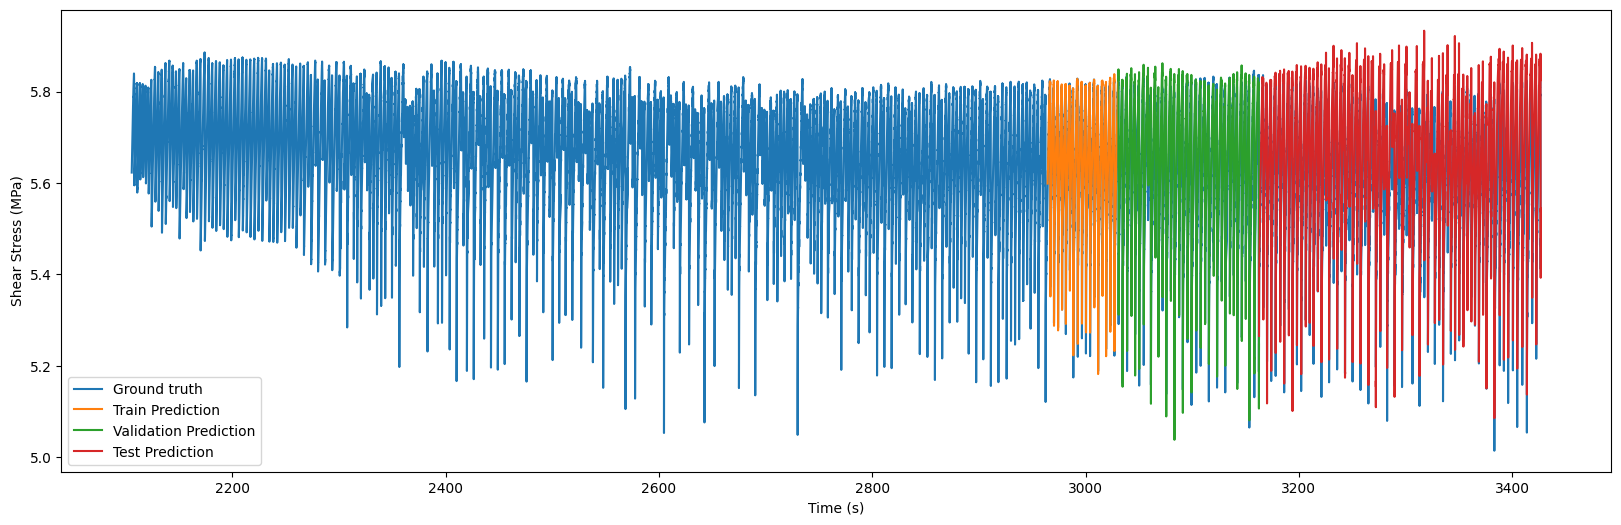

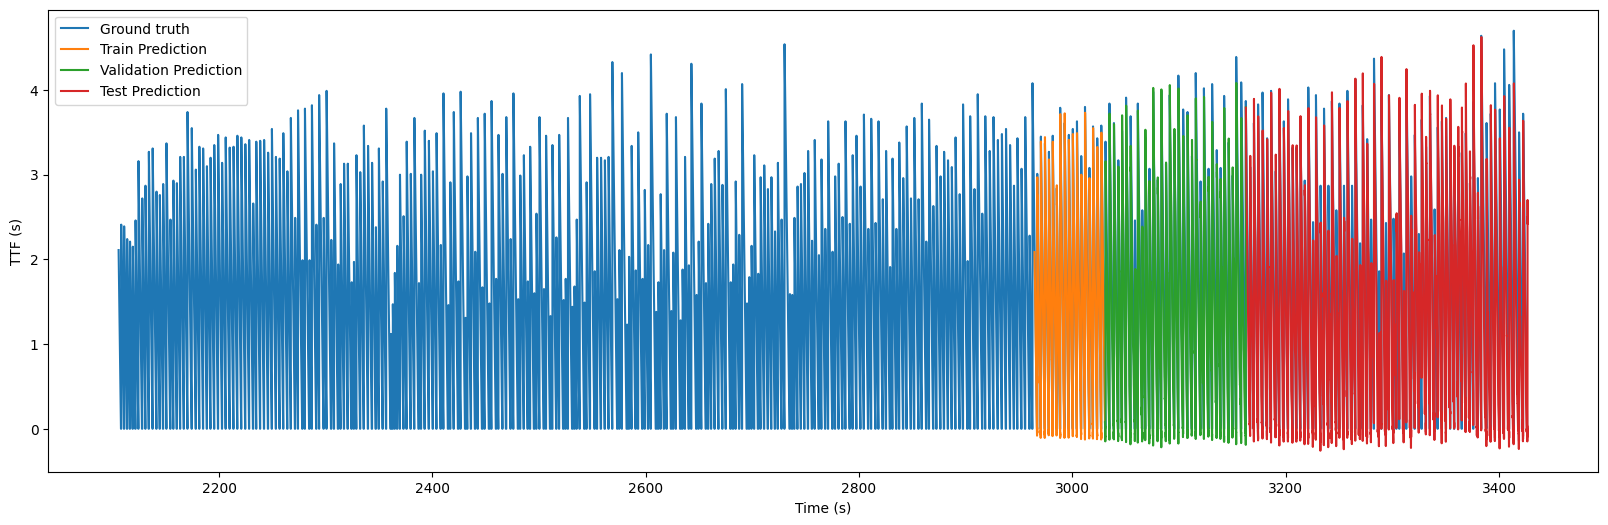

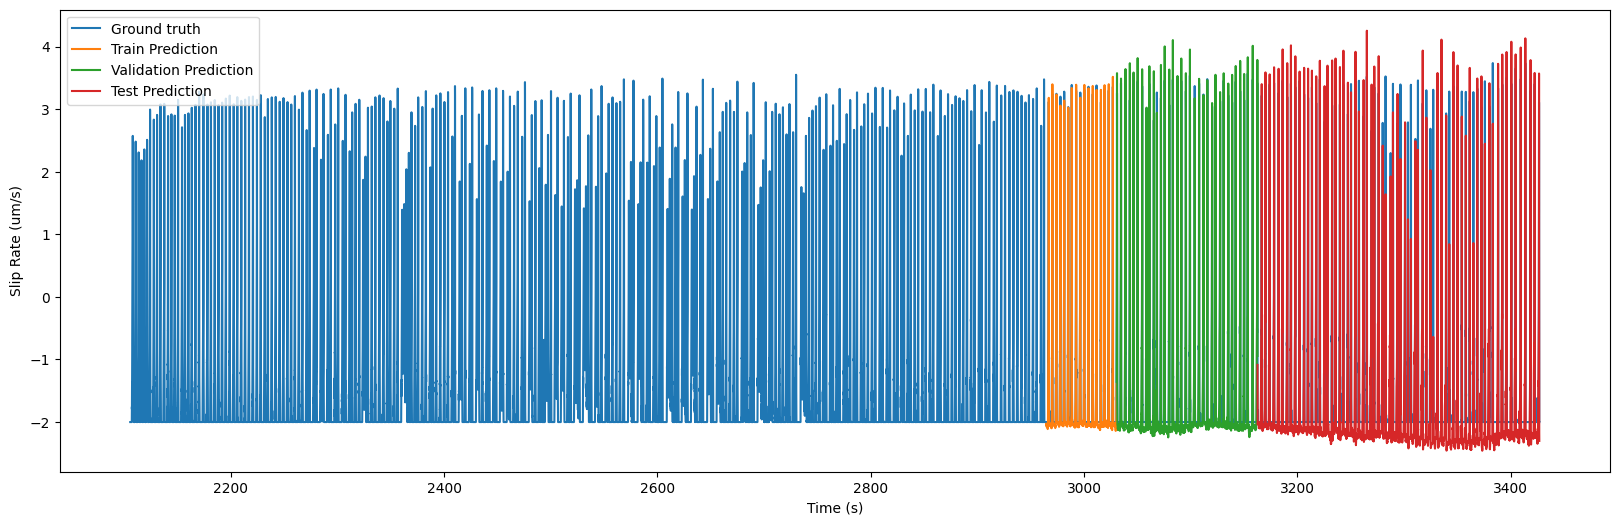

In [ ]:
# Overall plot:
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[85864:92469]

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_TTF)
plt.plot(traintime, y_predtrain_TTF)
plt.plot(valtime,  y_predval_TTF)
plt.plot(testtime, y_predtest_TTF)
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(3, figsize=(20,6))
plt.plot(ttime, ydf_SR)
plt.plot(traintime, y_predtrain_SR)
plt.plot(valtime,  y_predval_SR)
plt.plot(testtime, y_predtest_SR)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

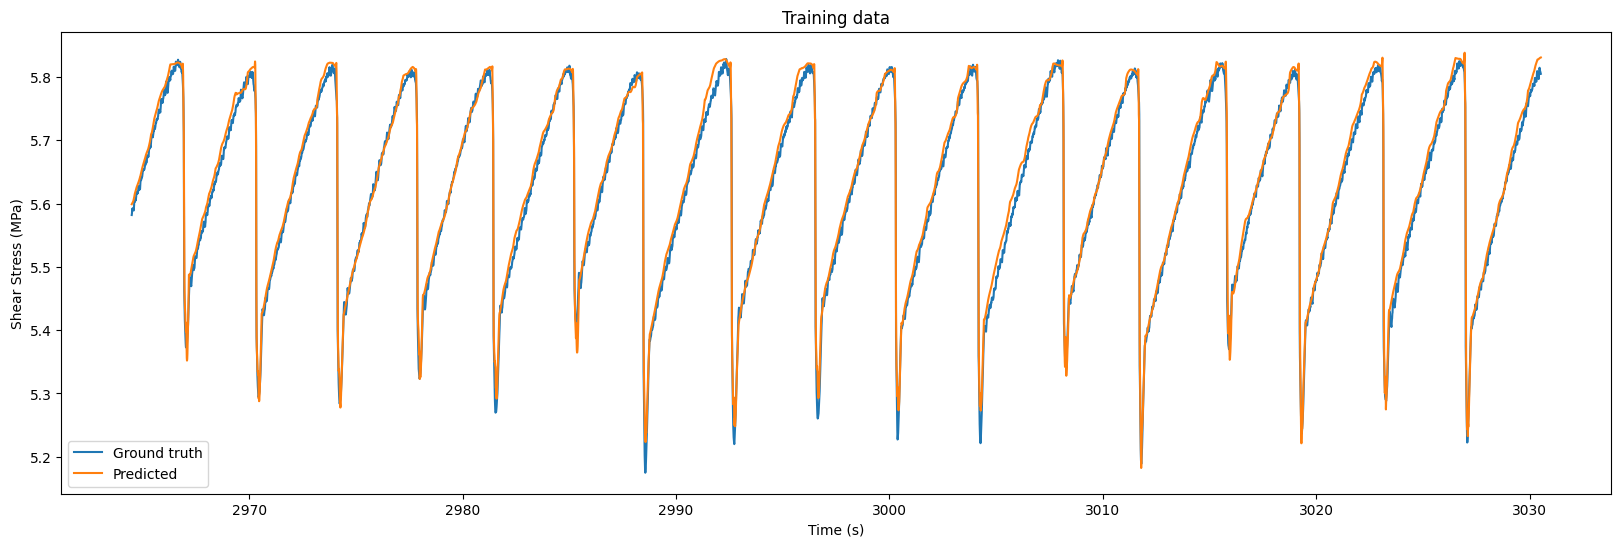

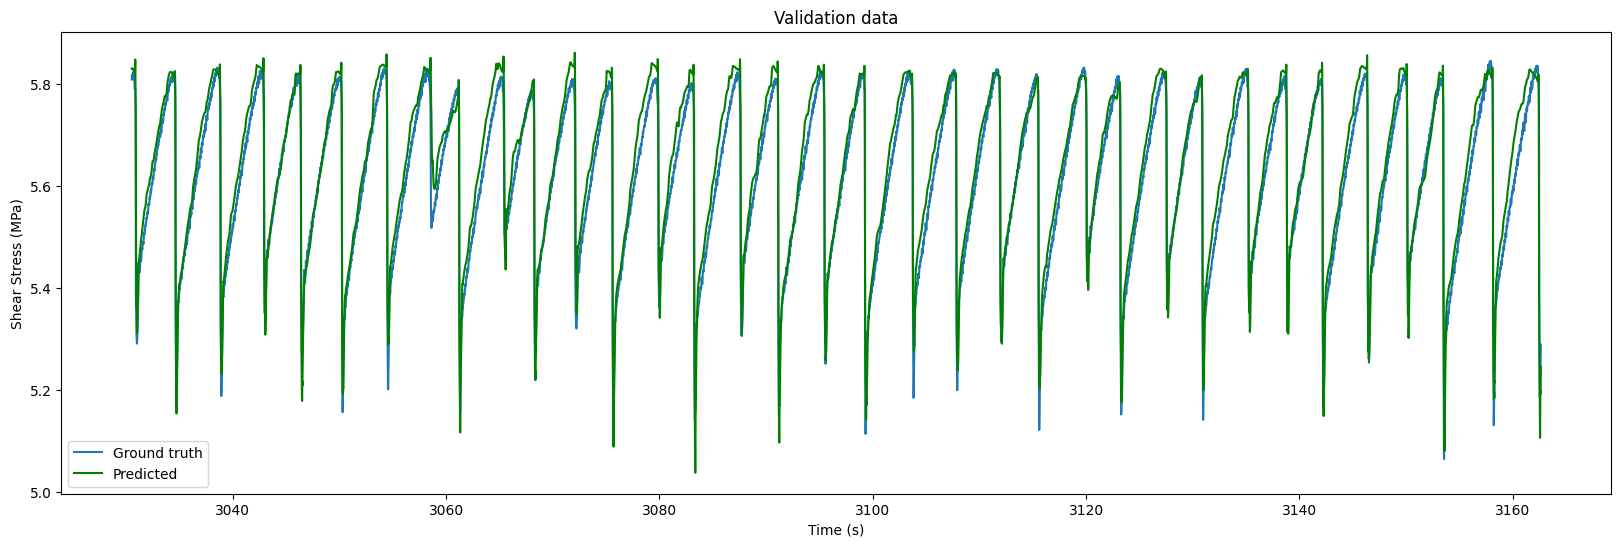

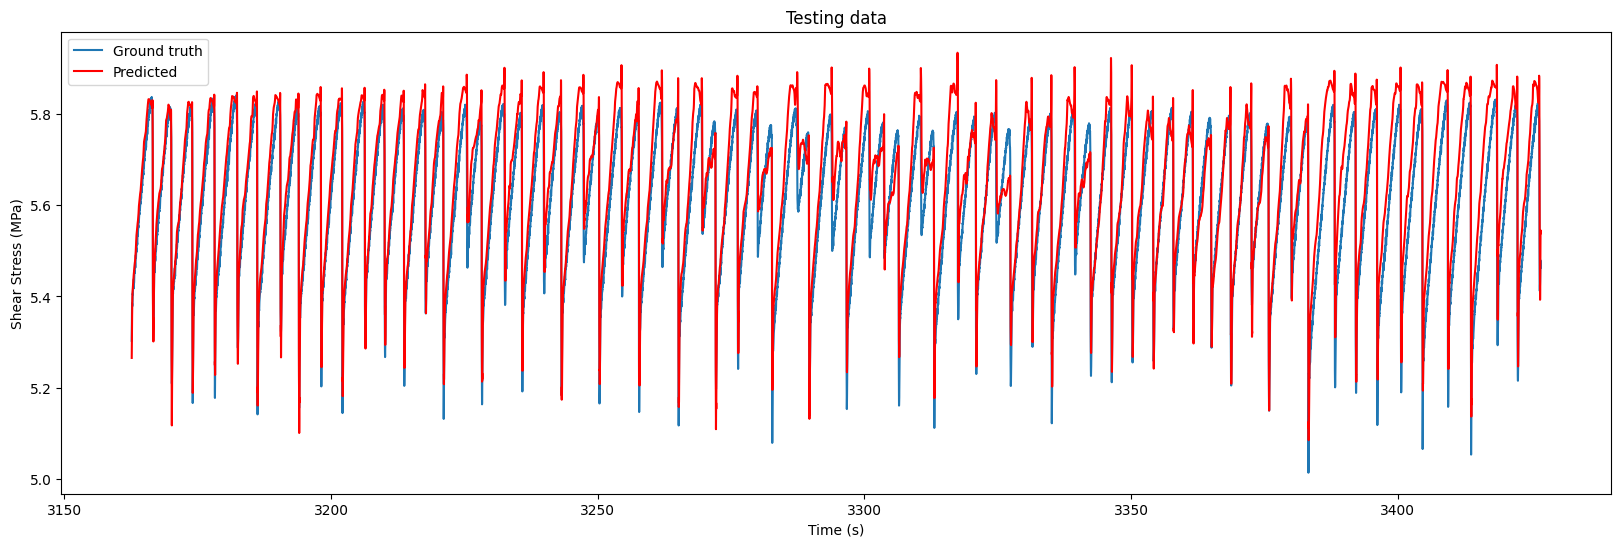

In [ ]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

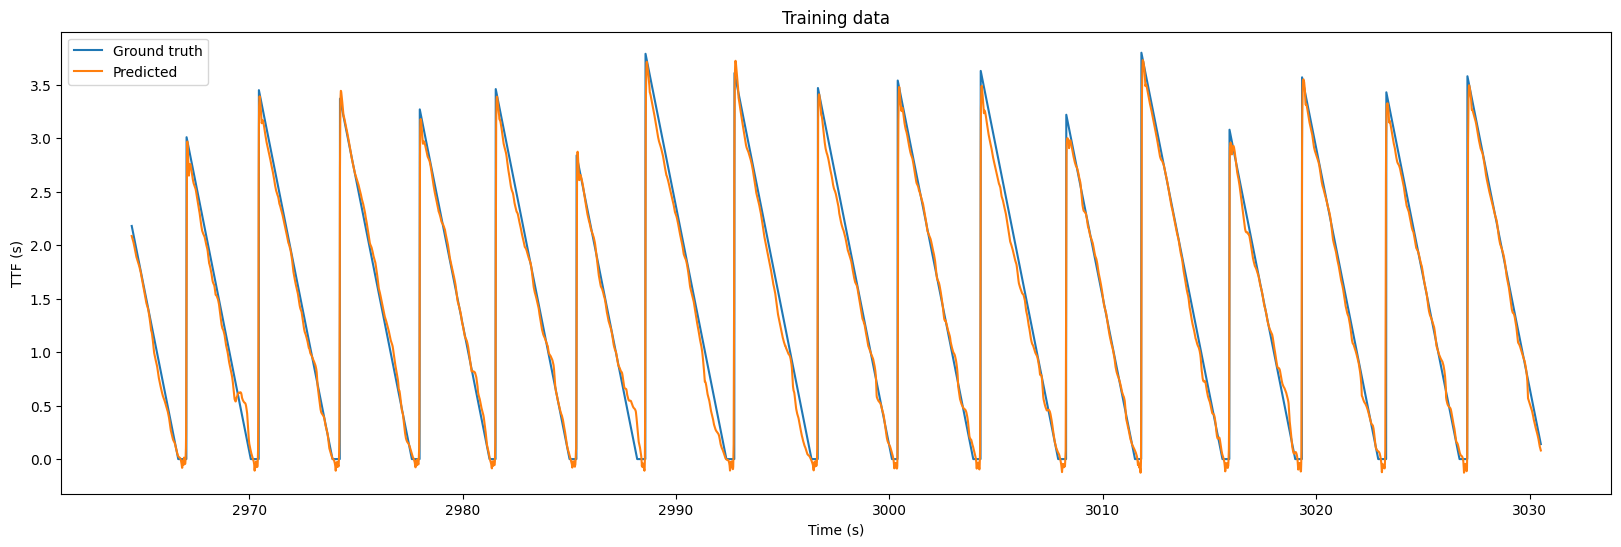

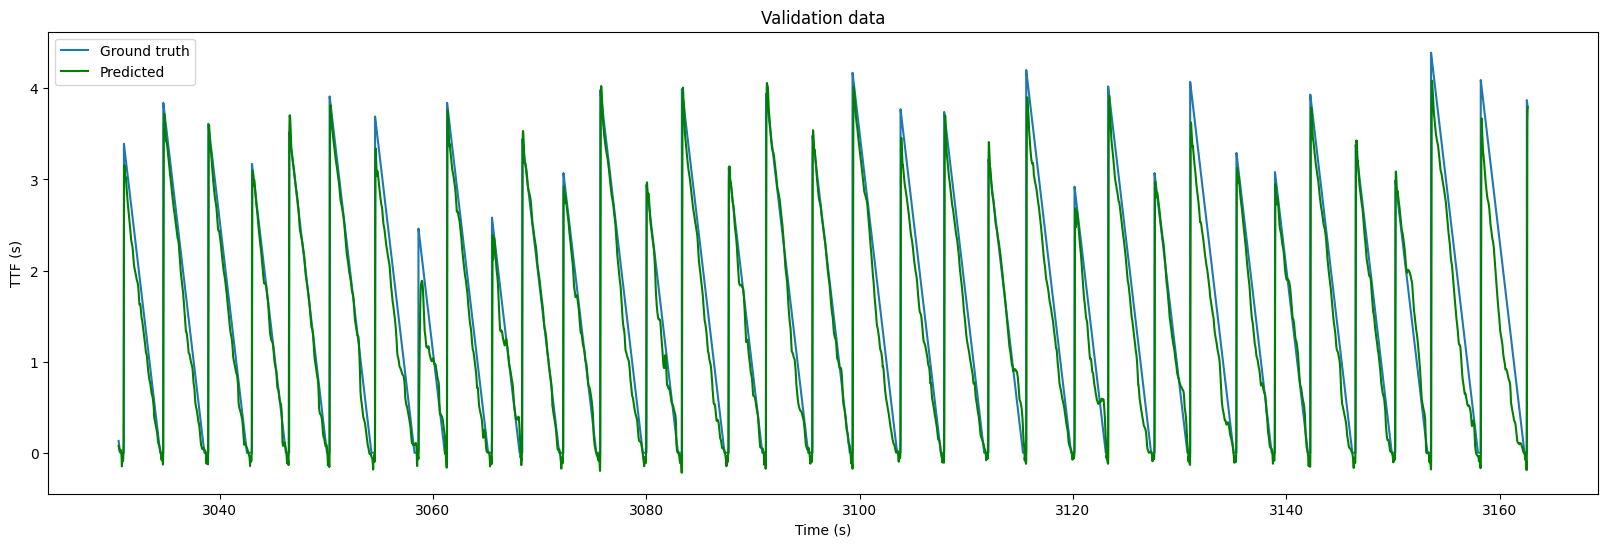

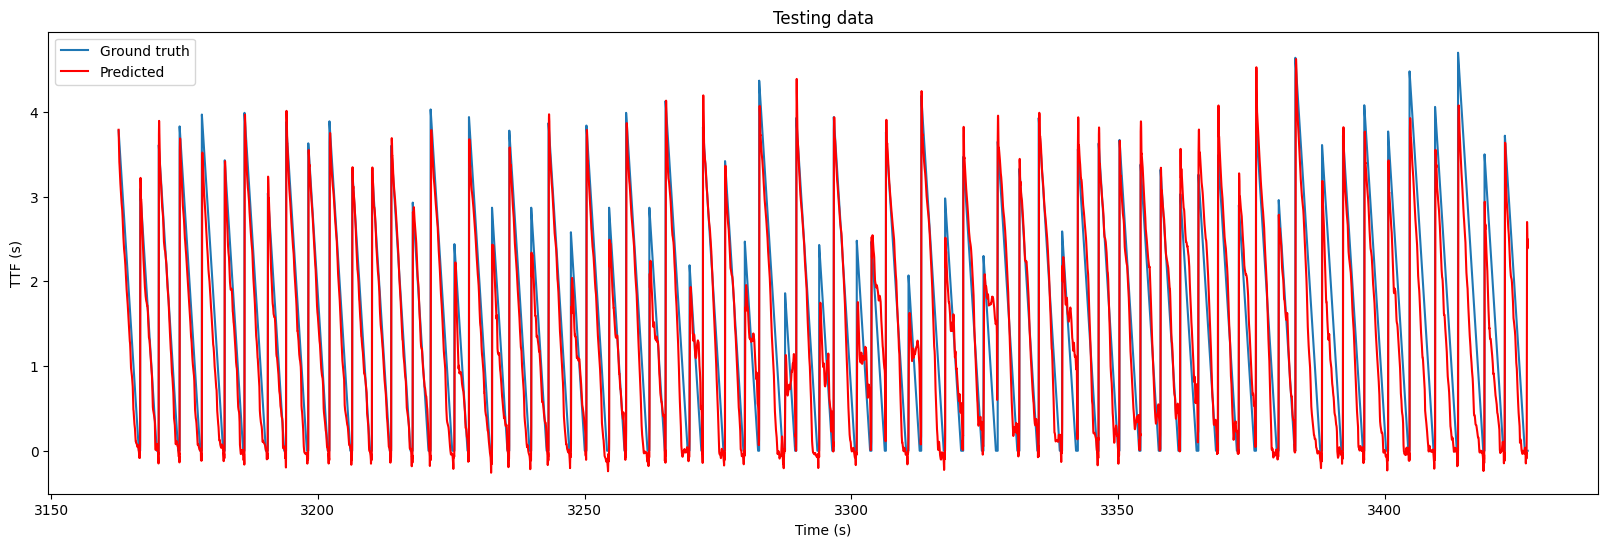

In [ ]:
# # Individual plot: TTF

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('TTF (s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_TTF, y_predtrain_TTF, 'Training data', '')
results_plot(2, valtime, Y_val_TTF, y_predval_TTF, 'Validation data', 'g')
results_plot(3, testtime, y_test_TTF, y_predtest_TTF, 'Testing data', 'r')

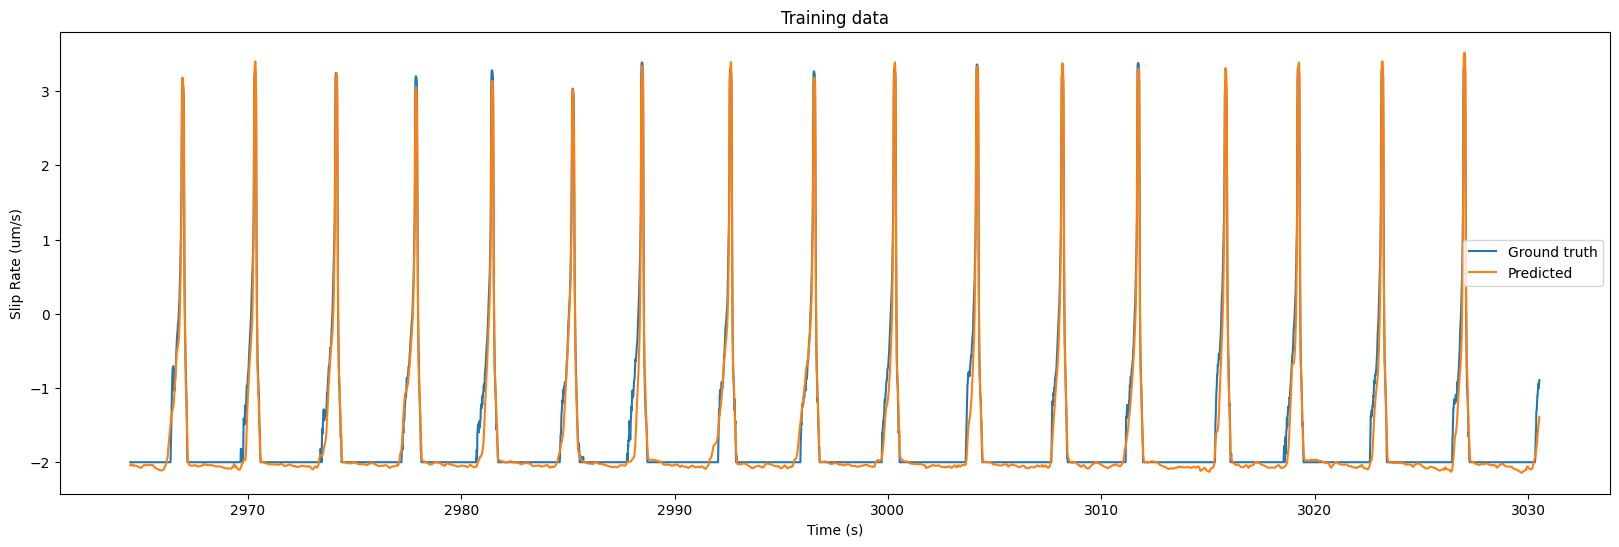

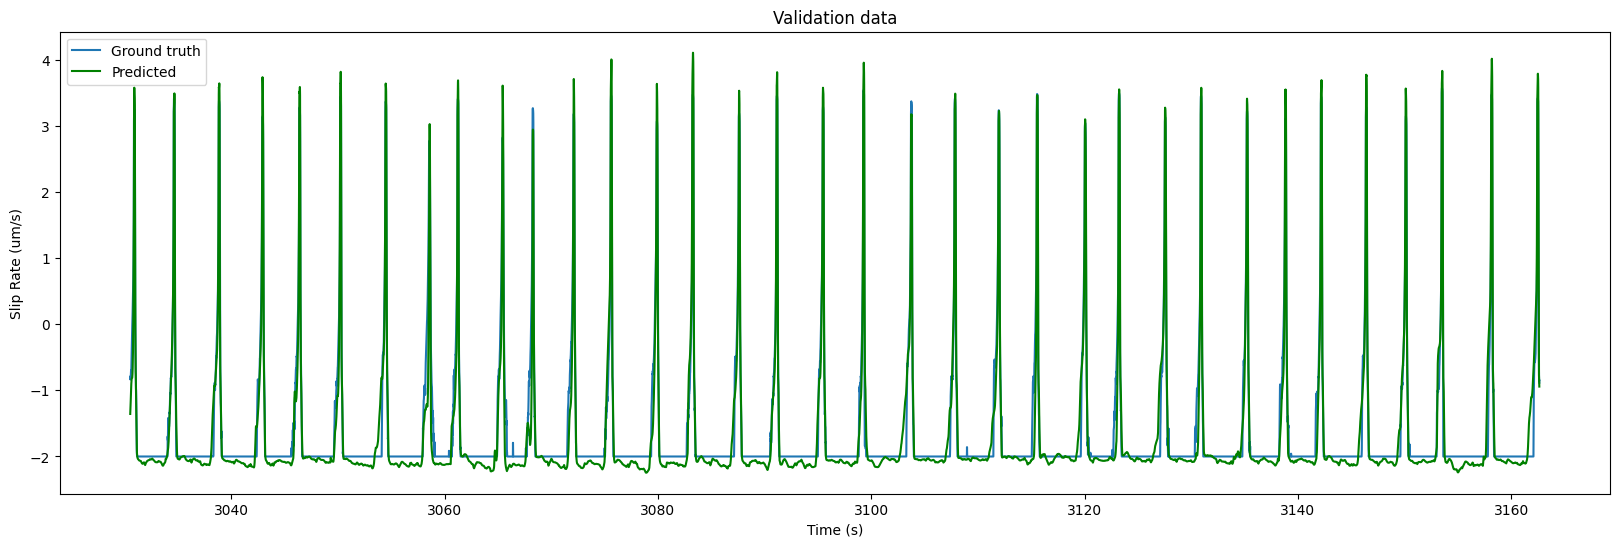

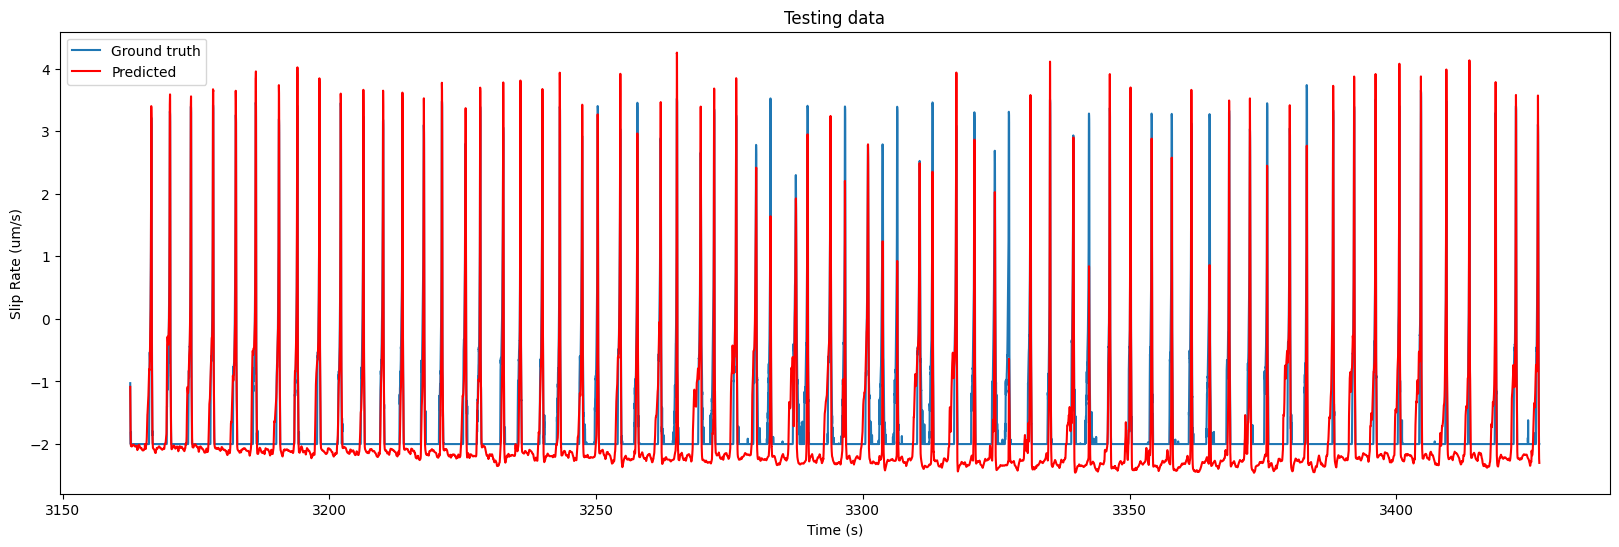

In [ ]:
# # Individual plot: SR

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SR, y_predtrain_SR, 'Training data', '')
results_plot(2, valtime, Y_val_SR, y_predval_SR, 'Validation data', 'g')
results_plot(3, testtime, y_test_SR, y_predtest_SR, 'Testing data', 'r')